<a href="https://colab.research.google.com/github/Ramesh466-an/CITREA-INDIA-TOUR/blob/main/Copy_of_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd


file_path = "/content/Dataset-04.csv"  # Update if necessary

df = pd.read_csv(file_path)

In [5]:
df.rename(columns={
    'PGA_g': 'pga',
    'Mw': 'mag',
    'Rjb_km': 'rjb',
    'Depth': 'hypd',
    'Vs30_m_s': 'vs30',
      'EqID': 'EqID',
    'SiteID':'siteID'
}, inplace=True)

###1a. MR distribution

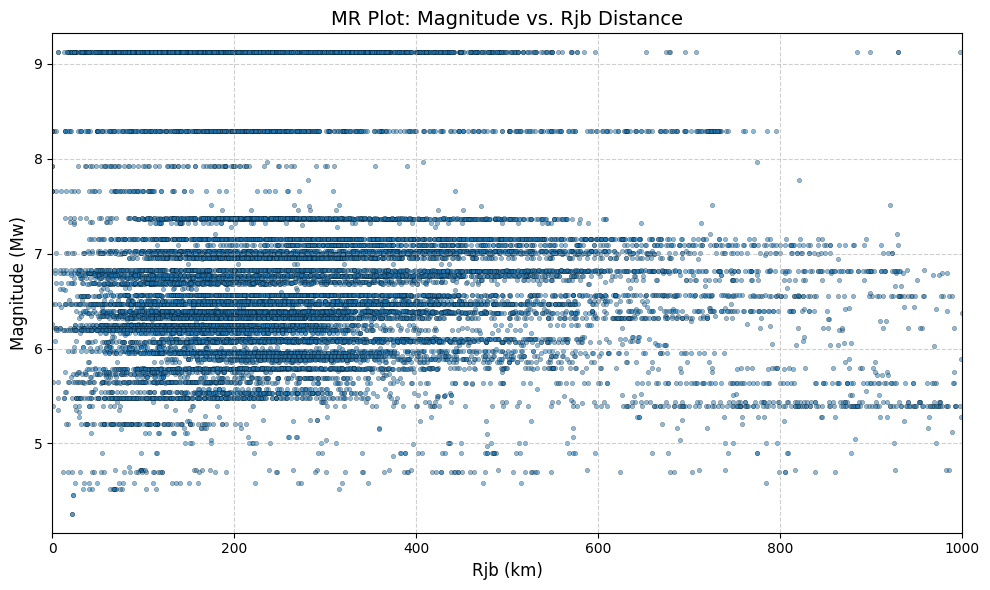

In [6]:

import matplotlib.pyplot as plt

# Ensure 'mag' and 'rjb' are in the DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(df['rjb'], df['mag'], s=10, alpha=0.5, edgecolors='k', linewidths=0.3)

plt.xlabel('Rjb (km)', fontsize=12)
plt.ylabel('Magnitude (Mw)', fontsize=12)
plt.title('MR Plot: Magnitude vs. Rjb Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1000)
plt.ylim(df['mag'].min() - 0.2, df['mag'].max() + 0.2)
plt.tight_layout()
plt.show()

###1b. Histogram

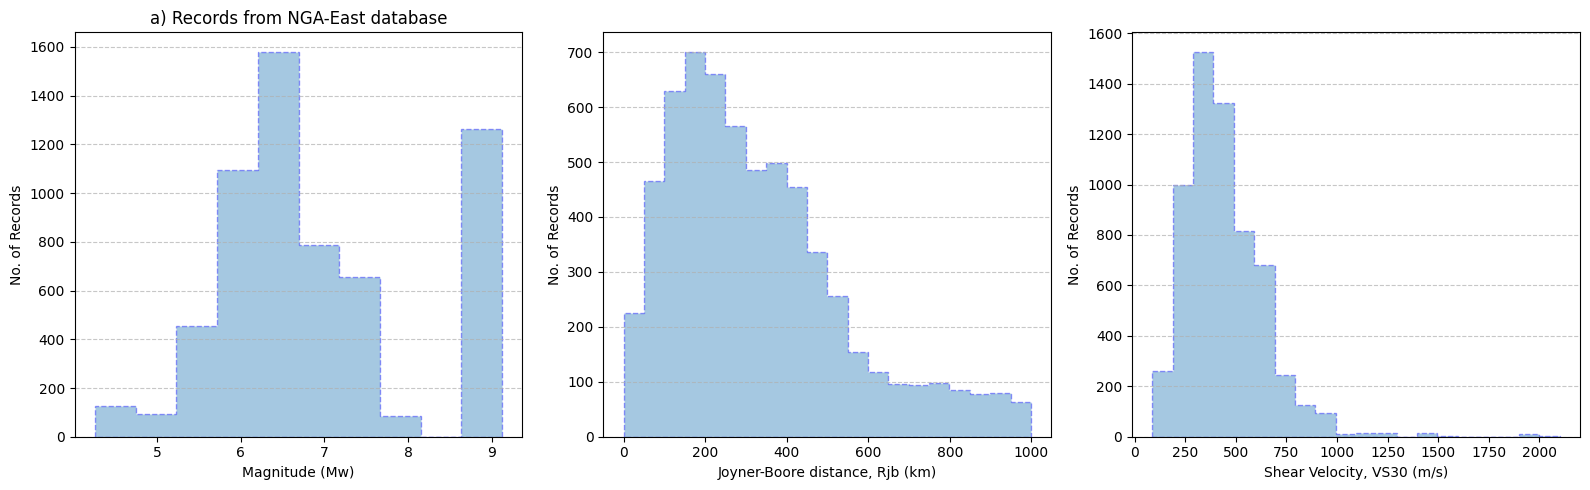

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# 1. Histogram for Magnitude (mag)
axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Histogram for Joyner-Boore Distance (rjb)
axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Histogram for VS30
axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)


# 3. Horizontal bar plot for Fault_Type
# Clean Fault_Type strings
# Convert 'Fault_Type' to string before applying .str.title()
#df["Fault_Type"] = df["Fault_Type"].astype(str).str.title() # Changed to convert to string
#fault_order = ["Strike Slip", "Normal", "Reverse", "Reverse Oblique"]
#fault_counts = df["Fault_Type"].value_counts().reindex(fault_order, fill_value=0)

#axs[3].barh(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='blue', hatch='//')
#axs[3].set_xlabel("No. of Records")
#axs[3].invert_yaxis()
#axs[3].grid(axis='x', linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

# --- Load & Filter Dataset -
#df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]
#meta_cols = ['mag', 'rjb', 'vs30']
#for col in meta_cols:
#    df = df[df[col] != -999]
#df = df[df['intra_inter'].isin([0, 1, 5])]
#is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
#is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
#df = df[is_interface | is_intraslab]
#df = df[(df['rjb'] <= 1000) & (df['sensor_depth'] <= 2)]
#df = df[(df['multi_event'] != 1) & (df['late_flag'] != 1)]
#df = df[df['src_flag'].isin([0, 1, 2, 4])]
#df = df[df['tgm'] >= 10]
#valid_eids = df['EqID'].value_counts()[lambda x: x >= 3].index
#df = df[df['EqID'].isin(valid_eids)]

# --- Preprocessing ---
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [col for col in df.columns if col.startswith('T') and 'pt' in col]

df['rjb'] = df['rjb'].replace(0, 0.01)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01)
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

df[target_cols] = df[target_cols].clip(lower=1e-6)
df[target_cols] = np.log(df[target_cols])  # Natural log

df_clean = df.dropna(subset=input_cols + target_cols)

X = df_clean[input_cols].values
Y = df_clean[target_cols].values
EqIDs = df_clean['EqID'].values
siteIDs = df_clean['siteID'].values

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# --- Splitting Data ---
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_scaled, Y_scaled, test_size=0.3, random_state=42, stratify=X_scaled[:, -1])
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=X_temp[:, -1])

# --- CVAE Definition ---
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 8  # Increased latent space

# Encoder
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs=input_layer, outputs=[z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(64, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output_layer = Dense(Y_train.shape[1], activation='linear')(x)
decoder = Model(inputs=latent_inputs, outputs=output_layer, name="decoder")

# Custom CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mse = MeanSquaredError()

    def compile(self, optimizer):
        super(CVAE, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            rec_loss = self.mse(y, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": rec_loss, "kl_loss": kl_loss}

    def test_step(self, data):
        x, y = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        rec_loss = self.mse(y, reconstruction)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = rec_loss + kl_loss
        return {"loss": total_loss, "reconstruction_loss": rec_loss, "kl_loss": kl_loss}

# --- Training ---
cvae = CVAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cvae.compile(optimizer=optimizer)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = cvae.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# --- Evaluation ---
z_mean_test, _, _ = encoder.predict(X_test)
y_pred_scaled = decoder.predict(z_mean_test)

y_pred = scaler_Y.inverse_transform(y_pred_scaled)
Y_test_unscaled = scaler_Y.inverse_transform(Y_test)

r2 = r2_score(Y_test_unscaled, y_pred)
mse = mean_squared_error(Y_test_unscaled, y_pred)
print(f"\nR² Score on Test Set: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


Epoch 1/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - kl_loss: 0.0019 - loss: 0.5698 - reconstruction_loss: 0.5678 - val_kl_loss: 2.1982e-04 - val_loss: 0.0023 - val_reconstruction_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.8944e-04 - loss: 0.5646 - reconstruction_loss: 0.5644 - val_kl_loss: 1.7312e-04 - val_loss: 0.0025 - val_reconstruction_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 9.9626e-05 - loss: 0.5672 - reconstruction_loss: 0.5671 - val_kl_loss: 5.4130e-05 - val_loss: 0.0022 - val_reconstruction_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 5.1811e-05 - loss: 0.5640 - reconstruction_loss: 0.5639 - val_kl_loss: 2.4672e-05 - val_loss: 0.0021 - val_reconstruction_loss: 0.0021 - learning_rate: 0.0010
Epoch 5/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 2.1560e-05 - loss: 0.6082 - reconstruction_loss:

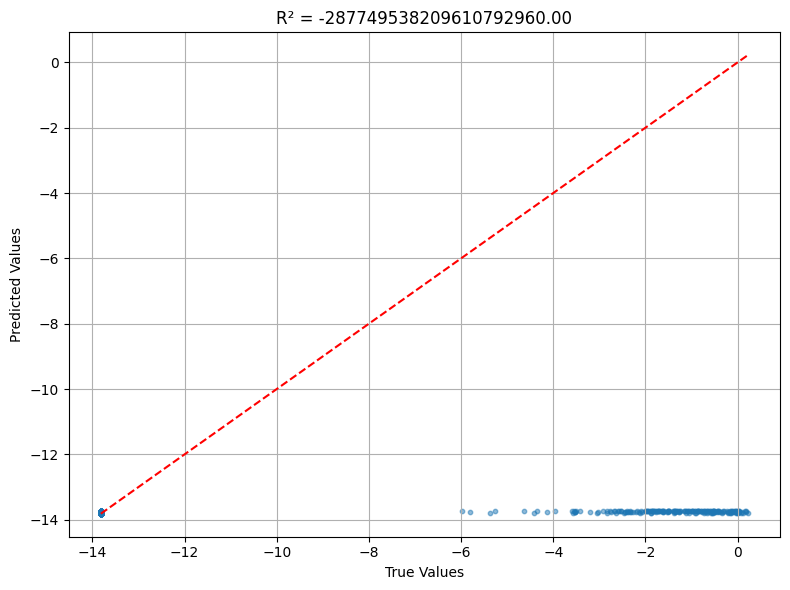

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))

# Assuming 'Y_test_unscaled' and 'y_pred' from the previous cell are the true and predicted values
plt.scatter(Y_test_unscaled, y_pred, alpha=0.5, s=10)

# Replace with the actual R-squared value obtained in the previous cell
overall_r2 = r2

plt.plot([np.min(Y_test_unscaled), np.max(Y_test_unscaled)],
         [np.min(Y_test_unscaled), np.max(Y_test_unscaled)], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"R² = {overall_r2:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

###3. Regression Plots

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


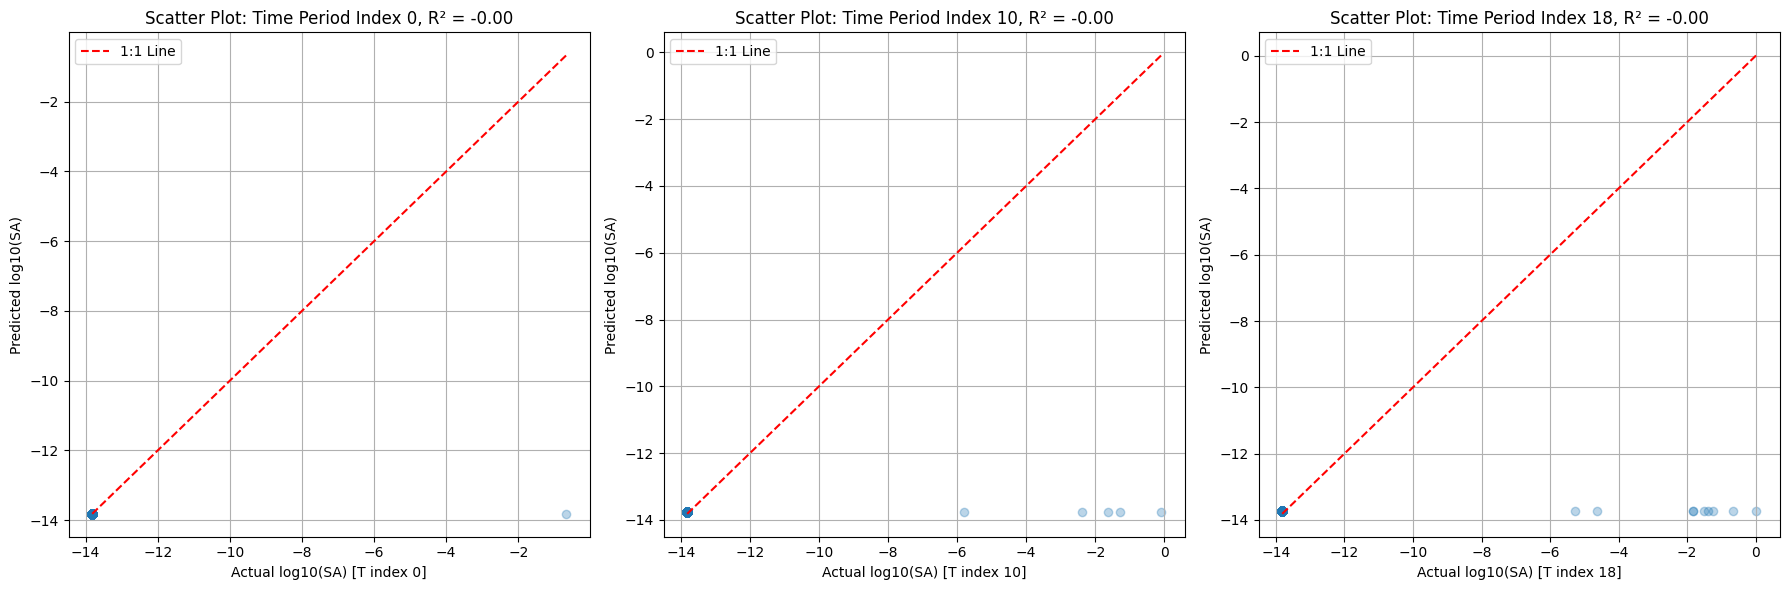

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Encode to latent space
z_mean, _, _ = encoder.predict(X_test) # Only provide X_test as input to the encoder

# Decode (i.e., reconstruct y)
y_pred_scaled = decoder.predict(z_mean)  # Use the encoded z_mean as input to the decoder

# ... (rest of your code) ...
# Inverse transform to original log scale (if you used a scaler)
# Use scaler_Y instead of scaler_target
y_pred_log = scaler_Y.inverse_transform(y_pred_scaled)
y_test_log = scaler_Y.inverse_transform(Y_test)

spectral_indices = [0, 10, 18]  # Choose relevant output indices

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(y_test_log[:, idx], y_pred_log[:, idx], alpha=0.3)
    ax.plot([y_test_log[:, idx].min(), y_test_log[:, idx].max()],
            [y_test_log[:, idx].min(), y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    # Calculate R2 for the current spectral index
    r2_current = r2_score(y_test_log[:, idx], y_pred_log[:, idx])

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}, R² = {r2_current:.2f}') #add R2 to title
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


###4. Inter-event & intra-event residuals

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-12-b5f8e7321a0d>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
<ipython-input-12-b5f8e7321a0d>:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
<ipython-input-12-b5f8e7321a0d>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df_plot.groupby('bin')[

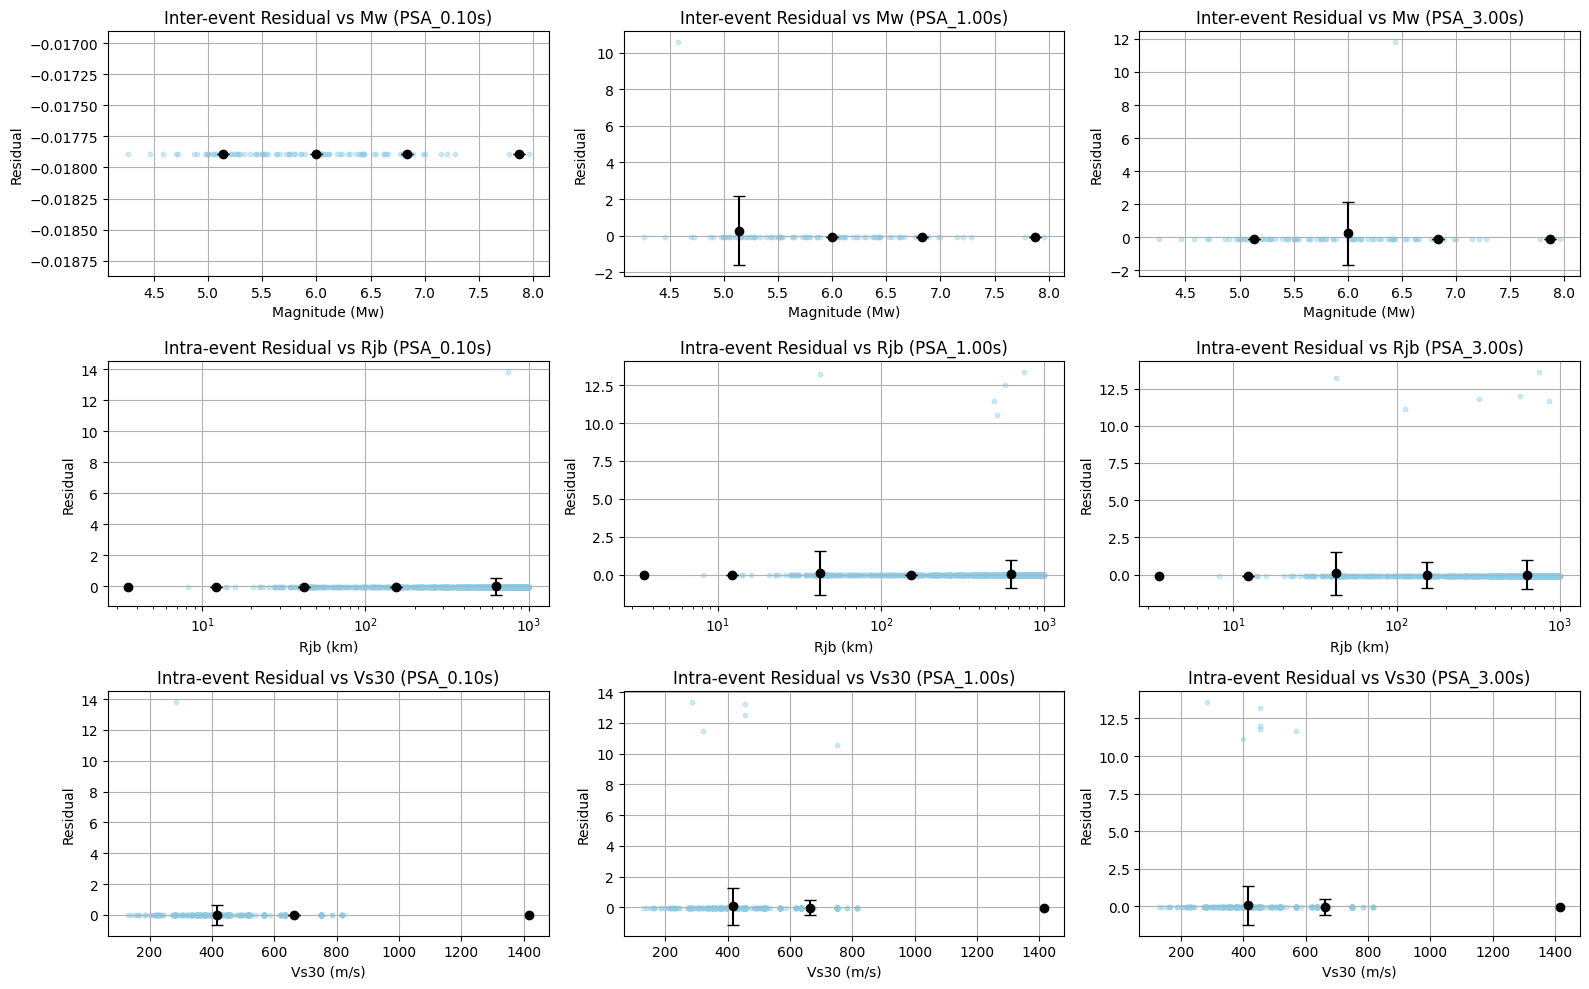

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Get predictions from CVAE ----
#z_mean, _, _ = encoder.predict([X_test, Y_test])
#y_pred_scaled = decoder.predict([X_test, z_mean])

# ---- 1. Get predictions from CVAE ----
z_mean, _, _ = encoder.predict(X_test) # Only provide X_test as input to the encoder
y_pred_scaled = decoder.predict(z_mean) # Only provide the encoded latent representation to the decoder


# ---- 2. Inverse scale to get log-space values ----
y_pred_log = scaler_Y.inverse_transform(y_pred_scaled)
y_test_log = scaler_Y.inverse_transform(Y_test)

# ---- 3. Compute residuals ----
residuals_log = y_test_log - y_pred_log

# ---- 4. Separate inter- and intra-event residuals ----
eq_unique, eq_idx_original = np.unique(EqIDs, return_index=True)
eq_idx = [idx for idx in eq_idx_original if idx < residuals_log.shape[0]]

inter_event = residuals_log[eq_idx]
intra_event = residuals_log

# ---- 5. Labels and Time Periods ----
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
selected_indices = [5, 12, 16]
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]




# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df_plot = pd.DataFrame({'x': x, 'y': y}) # Changed df to df_plot to avoid name conflict
    df_plot['bin'] = pd.cut(df_plot['x'], bins=bins) # Changed df to df_plot

    bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
    bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
    bin_stds = df_plot.groupby('bin')['y'].std() # Changed df to df_plot

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)







# ---- 6. Plotting ----
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Magnitude (Mw) for inter-event residuals
    Mw_vals = df['mag'].values[eq_idx_original]
    Mw_vals_filtered = Mw_vals[np.array(eq_idx_original) < residuals_log.shape[0]]

    plot_residual_binned(
        Mw_vals_filtered,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Rjb for intra-event
    plot_residual_binned(
        df['rjb'].values[:intra_event.shape[0]],
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Vs30 for intra-event
    plot_residual_binned(
        df['vs30'].values[:intra_event.shape[0]],
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )

plt.tight_layout()
plt.show()


###5a. Predicted SA sensitivity wrt Mw

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

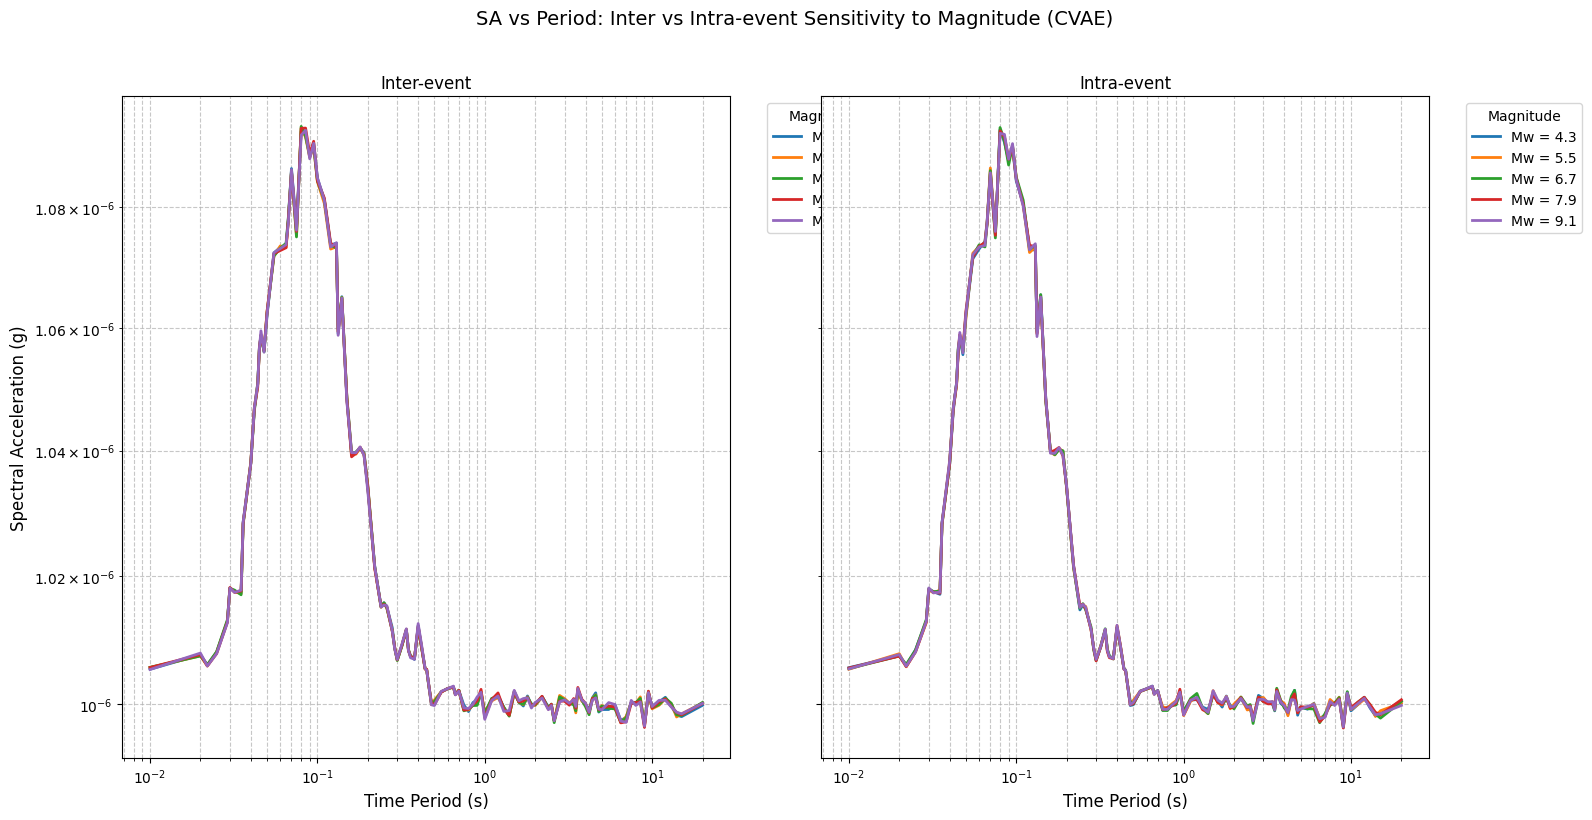

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Periods from target column names
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed input values
fixed_rjb = 10.0
fixed_vs30 = 760.0
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Magnitude range
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 5)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        # 1. Construct input
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # 2. Sample z and generate predictions
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))  # latent_dim: set this to match your CVAE
            #y_pred_scaled = decoder.predict([X_scaled, z])
            y_pred_scaled = decoder.predict(z)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)

        # 3. Mean prediction → log space → exp
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        # 4. Plot
        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred, label=label, linewidth=2)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.set_xscale('log')
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude (CVAE)", fontsize=14, y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()


###5b. Predicted SA sensitivity wrt Rjb

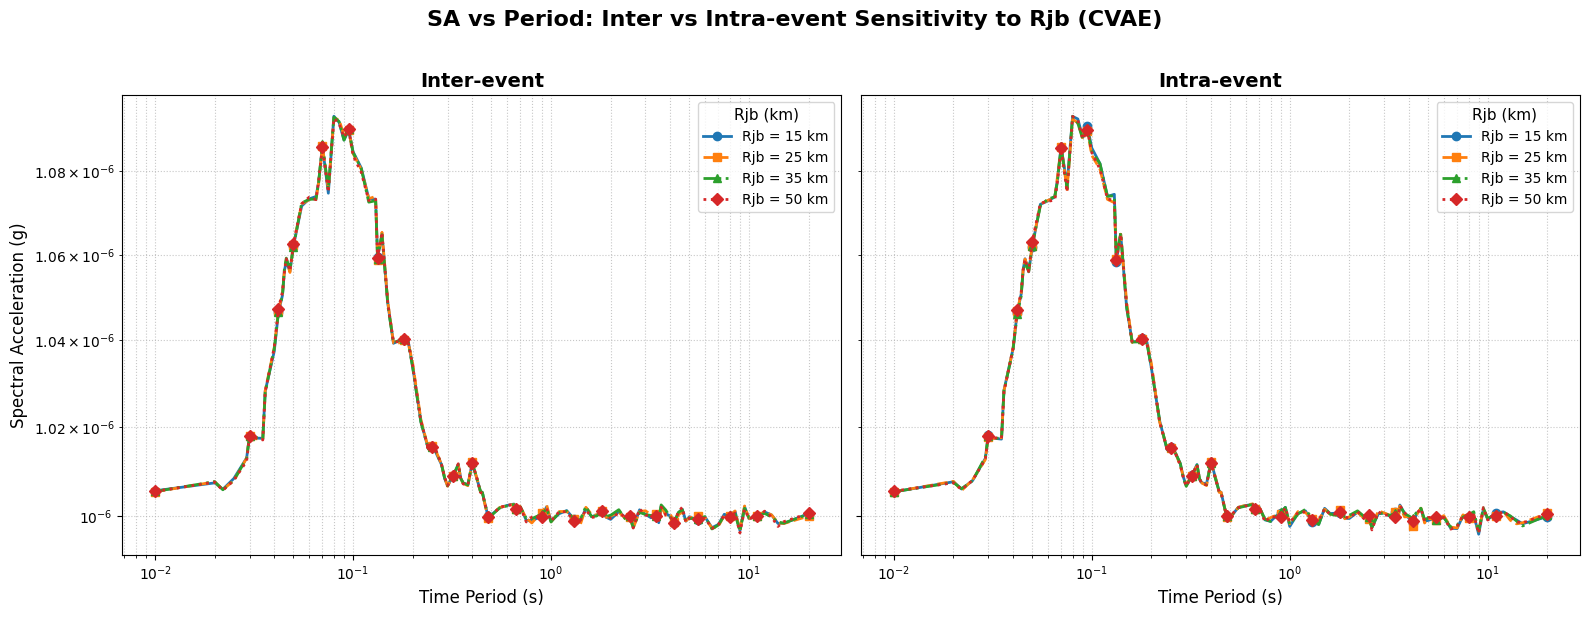

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert periods from target column names
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_mw = 6.5
fixed_vs30 = 760.0
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Rjb values to test
rjb_values = [15, 25, 35, 50]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# Latent dimension for CVAE
latent_dim = 8  # ⬅️ Change this to match your model's latent space

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # Generate predictions from CVAE
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))
            #y_pred_scaled = decoder.predict([X_scaled, z], verbose=0)
            y_pred_scaled = decoder.predict(z, verbose=0)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        label = f'Rjb = {rjb} km'
        ax.plot(periods, y_pred,
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markevery=5,
                linewidth=2,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb (CVAE)", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


###5c. Predicted SA sensitivity wrt VS30

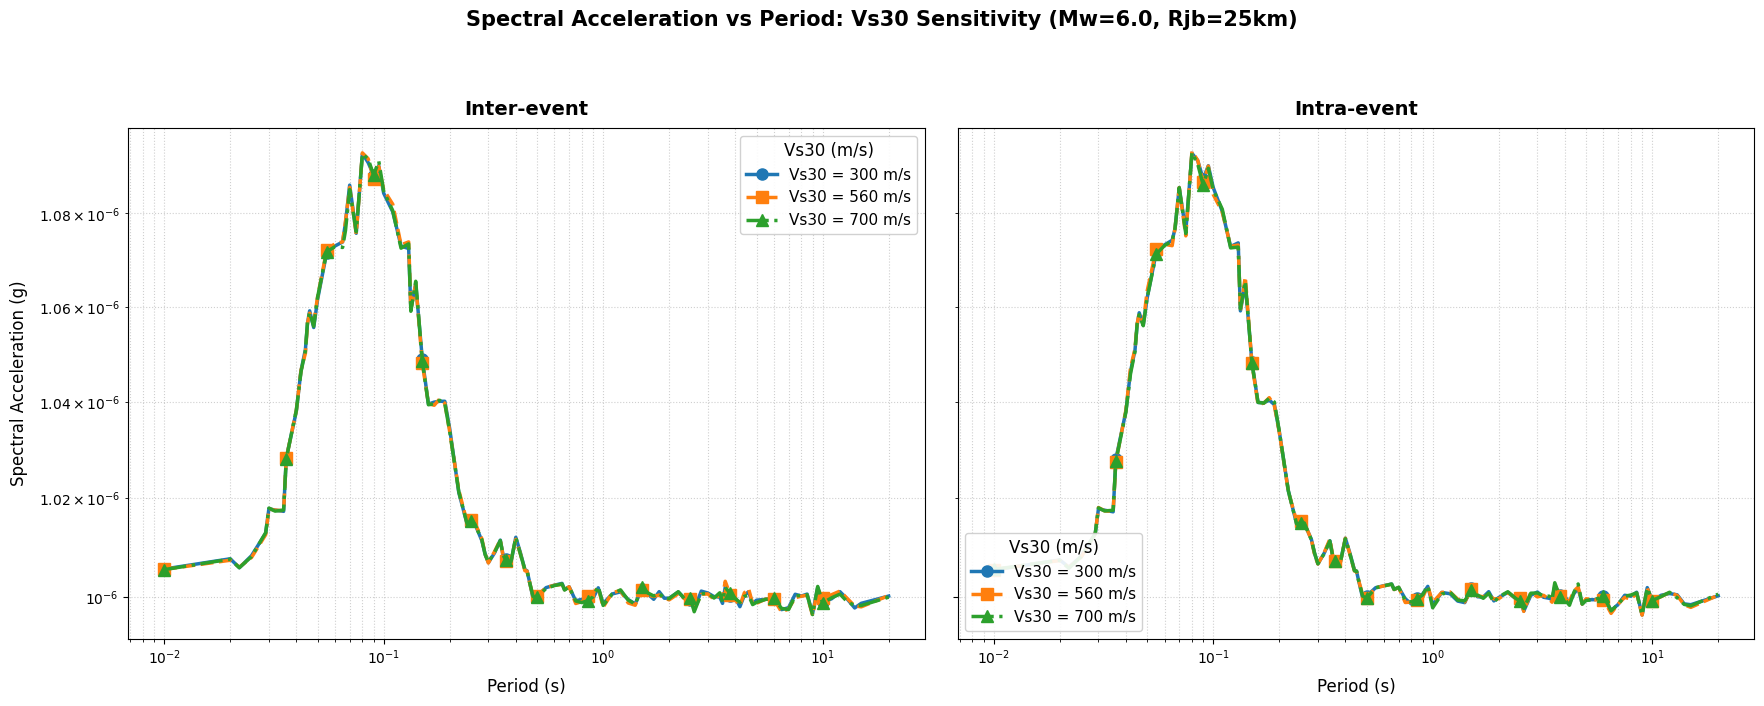

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert period strings to floats
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed inputs
fixed_mw = 6.0
fixed_rjb = 25.0
logrjb = np.log10(max(fixed_rjb, 0.01))

vs30_values = [300, 560, 700]
styles = {
    300: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

latent_dim = 8  # 🔁 Set this to match your CVAE latent dimension

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # Sample predictions from CVAE decoder
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))
            # The decoder only expects the latent representation 'z' as input
            y_pred_scaled = decoder.predict(z, verbose=0)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        ax.plot(periods, y_pred,
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                 fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title="Vs30 (m/s)",
              fontsize=11,
              title_fontsize=12,
              framealpha=0.9,
              loc='upper right' if intra_inter_val == 0 else 'lower left')

plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.0, Rjb=25km)",
             fontsize=15, weight='bold', y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

###6. Predicted SA with respect to Rjb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_cvae_prediction(X_input, iT, num_samples=100):
    X_scaled = scaler_X.transform(X_input)
    X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

    z_mean, z_log_var, _ = encoder(X_tensor)

    preds = []
    for _ in range(num_samples):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sample = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        y_pred_scaled = decoder(z_sample)
        y_pred = scaler_Y.inverse_transform(y_pred_scaled.numpy())
        preds.append(np.exp(y_pred[:, iT]))  # inverse log and extract iT column

    preds = np.array(preds)
    return preds.mean(axis=0)[0]  # Return mean SA for single input



selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

rjb_range = np.linspace(df['rjb'].min(), df['rjb'].max(), 100)
mw_values = [5.0, 6.0, 7.0]
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

# ========== 1. Inter-event (τ) Components ==========
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # inter-event
            sa = get_cvae_prediction(X_input, iT)
            sa_values.append(sa)

        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ========== 2. Intra-event (ϕ) Components ==========
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # intra-event
            sa = get_cvae_prediction(X_input, iT)
            sa_values.append(sa)

        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


###7. table of inter, intra, and total standard deviation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Replace with your true and predicted values
# Example:
# y_test: numpy array (num_samples, num_targets)
# y_pred: numpy array (num_samples, num_targets)
# target_columns: list of target column names like ['T0pt', 'T1pt', ...]

# Dummy placeholders for this example (replace with actual values)
target_columns = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]
y_test = np.random.rand(200, len(target_columns))
y_pred = y_test + np.random.normal(0, 0.1, y_test.shape)

# Optional: event_ids for inter/intra event std dev
# event_ids should be a 1D array of length y_test.shape[0] indicating event label
event_ids = np.random.randint(0, 10, size=y_test.shape[0])

# Calculate metrics
results = []
for i, col in enumerate(target_columns):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    residuals = y_test[:, i] - y_pred[:, i]

    # Inter-event std (τ) and Intra-event std (ϕ)
    df = pd.DataFrame({'residuals': residuals, 'event': event_ids})
    inter_event_std = df.groupby('event').mean()['residuals'].std()       # τ
    intra_event_std = df.groupby('event').std()['residuals'].mean()       # ϕ
    total_std = np.sqrt(inter_event_std**2 + intra_event_std**2)

    results.append([col, r2, inter_event_std, intra_event_std, total_std])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Target', 'R²', 'τ (Inter Std)', 'ϕ (Intra Std)', 'Total Std Dev'])

# Display as table using matplotlib
def plot_table(df):
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(df) + 1))
    ax.axis('off')

    # Convert numeric columns to strings with desired rounding
    numeric_cols = df.columns[1:]  # Exclude the 'Target' column
    df[numeric_cols] = df[numeric_cols].apply(lambda x: pd.Series(np.round(x, 4), index=x.index))

    tbl = ax.table(cellText=df.values,
                   colLabels=df.columns,
                   cellLoc='center',
                   loc='center')
    tbl.scale(1, 1.5)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    plt.title("CVAE Target-wise Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_table(results_df)

# Optional: Save as image
# fig.savefig("bnn_metrics_table.png", dpi=300)

###hyperparameter tuning

In [ ]:
def build_cvae(hidden_units, latent_dim, learning_rate):
    # Encoder
    input_layer = Input(shape=(X_train.shape[1],))
    x = Dense(hidden_units[0], activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(hidden_units[1], activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])
    encoder = Model(input_layer, [z_mean, z_log_var, z])

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(hidden_units[1], activation='relu')(latent_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(hidden_units[0], activation='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(Y_train.shape[1], activation='linear')(x)
    decoder = Model(latent_inputs, output_layer)

    # CVAE Model
    cvae = CVAE(encoder, decoder)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cvae.compile(optimizer=optimizer)
    return cvae, encoder, decoder


In [ ]:
import matplotlib.pyplot as plt

neurons_list = [(64, 32), (128, 64), (256, 128), (512, 256)]
mse_list, r2_list = [], []

for units in neurons_list:
    cvae, enc, dec = build_cvae(units, latent_dim=8, learning_rate=0.001)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=100, batch_size=32, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)
    y_true = scaler_Y.inverse_transform(Y_test)

    mse_list.append(mean_squared_error(y_true, y_pred))
    r2_list.append(r2_score(y_true, y_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([f"{a}-{b}" for a, b in neurons_list], mse_list, marker='o')
plt.title("MSE vs Hidden Neurons")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.plot([f"{a}-{b}" for a, b in neurons_list], r2_list, marker='o', color='green')
plt.title("R² vs Hidden Neurons")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()


In [ ]:
epoch_list = [50, 100, 150, 200]
mse_epochs = []

for ep in epoch_list:
    cvae, enc, dec = build_cvae((128, 64), latent_dim=8, learning_rate=0.001)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=ep, batch_size=32, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)
    mse_epochs.append(mean_squared_error(scaler_Y.inverse_transform(Y_test), y_pred))

plt.plot(epoch_list, mse_epochs, marker='o')
plt.title("MSE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid(True)
plt.show()
